In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter

from tqdm.auto import tqdm

from support import show_batch

import warnings

In [2]:
warnings.filterwarnings(action='ignore')

# Data 

In [3]:
#download and extract the data
# ! curl --output pokemon.zip http://d2l-data.s3-accelerate.amazonaws.com/pokemon.zip
# ! unzip pokemon.zip

In [4]:
# transform the images into tensors and normalize the images
transform = transforms.Compose(
    [transforms.Resize((512, 512)),transforms.ToTensor(), transforms.Normalize((.5,), (.5,))])

In [5]:
#create a datast of the sprites
ds = torchvision.datasets.ImageFolder(
        root="pokemon",
        transform=transform)
loader = DataLoader(ds, 64, shuffle=True, num_workers=16)

/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette imag

(<Figure size 1296x1296 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2aab6c07c0b8>)

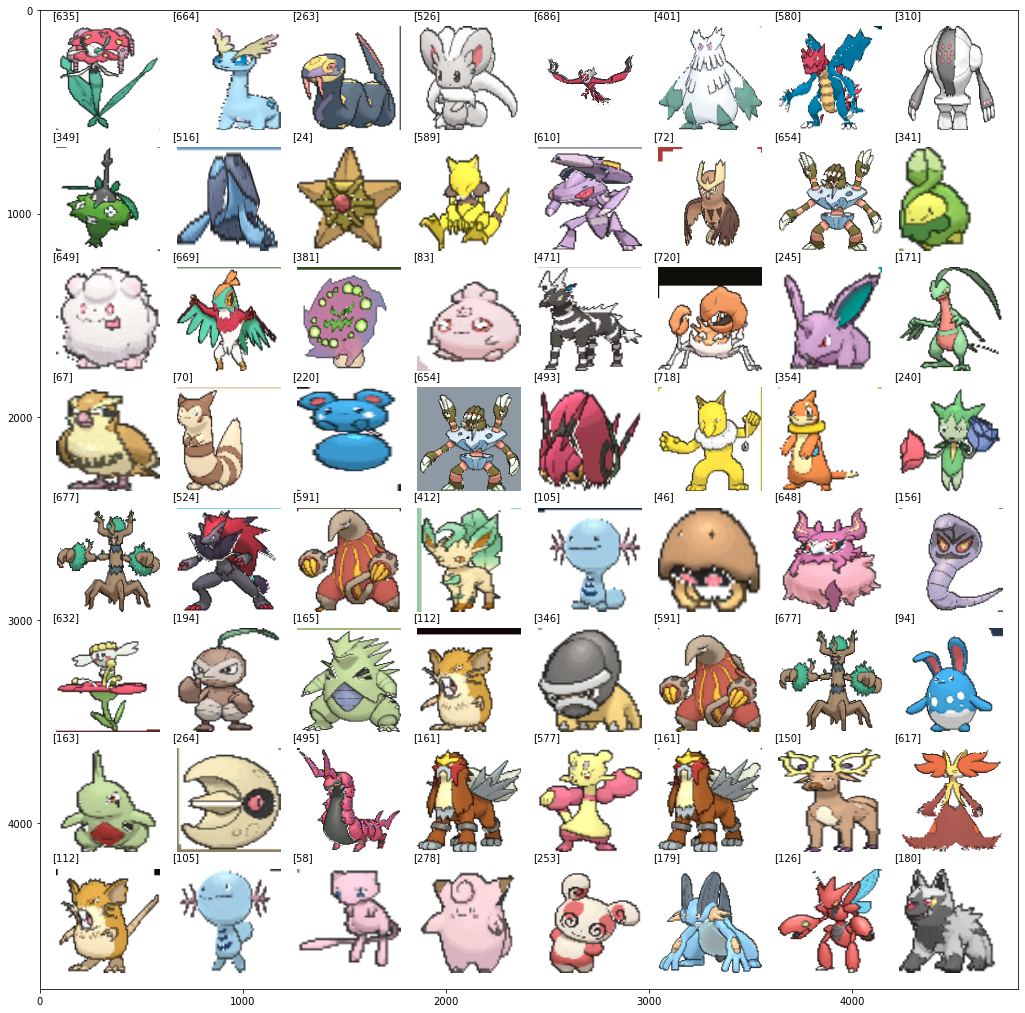

In [6]:
# show a batch
batch = next(iter(loader))
X, y = batch
show_batch(X, y)

# Model Setup

In [7]:
class G_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, strides=2, padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        
        self.conv2d_trans = nn.ConvTranspose2d(
            in_channels,
            out_channels, 
            kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_trans(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x

In [8]:
class Generator(nn.Module):
    """Generates a 512px image from a latent vector
    """
    def __init__(self, latent_dim=100, **kwargs):
        super(Generator, self).__init__(**kwargs)
        
        img_size=512
        self.net = nn.Sequential(
#             G_block(latent_dim, img_size*64, strides=1, padding=0),  # output: (img_size*64, 4, 4)
#             G_block(img_size*64, img_size*32),  # output: (img_size*32, 8, 8)
            G_block(100, img_size*16),  # output: (img_size*16, 16, 16)
            G_block(img_size*16, img_size*8),  # output: (img_size*8, 32, 32)
            G_block(img_size*8, img_size*4),  # output: (img_size*4, 64, 64)
            G_block(img_size*4, img_size*2),  # output: (img_size*2, 128, 128)
            G_block(img_size*2, img_size),   # output: (img_size, 256, 256)
            nn.ConvTranspose2d(img_size, 3, kernel_size=4, 
                               stride=2, padding=1, bias=False),  # output: (3, 512, 512)
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.net(x)

In [9]:
# check output is as expected

x = torch.normal(0, 1, (1, 100, 8, 8)).cuda()
print("input shape", x.shape)
net_G = Generator(latent_dim=100).cuda()
output = net_G(x)
print("output shape should be 1, 3, 512, 512", output.shape)

input shape torch.Size([1, 100, 8, 8])
output shape should be 1, 3, 512, 512 torch.Size([1, 3, 512, 512])


In [10]:
class Discriminator(nn.Module):
    """Discriminates a 512px image from the real 1 or generated 0 distribution
    """
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        
        self.base = nn.Sequential(
            *list(models.resnet18(pretrained=False).children())[:-2]
        )
       
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.max_pool = nn.AdaptiveMaxPool2d(output_size=1)
        self.batch_norm = nn.BatchNorm1d(
                    1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                )
        
        self.classifier_head = nn.Sequential(
            *[
                nn.Linear(1024, 512, bias=True),
                nn.ReLU(),
                nn.BatchNorm1d(
                    512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                ),
                nn.Dropout(p=0.5),
                nn.Linear(512, 1, bias=True),
            ]
        )
        
    def forward(self, x):
        x = self.base(x)
    
        x_avg = self.avg_pool(x)
        x_max = self.max_pool(x)

        #cat max and avg
        x = torch.cat([x_avg, x_max], dim=1)

        #flatten and to batch norm / drop out
        x = nn.Flatten()(x)
        x = self.batch_norm(x)
        x = nn.Dropout(p=0.25)(x)

        # now classify it
        x = self.classifier_head(x)
        
        return x #note needs softmax

In [11]:
# check output
x = torch.normal(0, 1, (2, 3, 512, 512))
net_D = Discriminator()
net_D(x)

tensor([[0.2654],
        [0.5142]], grad_fn=<AddmmBackward>)

# Train

In [12]:
def get_sample_Z(batch_size, latent_dim):
    return torch.normal(0, 1, (batch_size, latent_dim, 8, 8))

In [13]:
def update_D(X, Z, net_Discriminator, net_Generator, loss_func, optim, device_id=0):
    batch_size = X.shape[0]
    
    device = f'cuda:{device_id}'
    ones = torch.ones(batch_size).to(device) # here we must set this to the first device for D
    zeros = torch.zeros(batch_size).to(device)
    
   
    # all of these should come back as real (1) but as the generator and discriminator play their game
    # the discriminator will get bad at this task 
    real_Y = net_Discriminator(X).squeeze()
    
    # Generate fake_X but detatch from gradients. We dont want update the generator at this time
    fake_X = net_Generator(Z).detach().to(device)
    
    # This should be all fake (0) but as the generator gets better, it will fool the discriminator
    fake_Y = net_Discriminator(fake_X).squeeze()
    
    # calc the loss, the sum of all the real ones the discriminator got wrong and 
    # all the fakes it was fooled by
    real_loss = loss_func(real_Y, ones)
    fake_loss = loss_func(fake_Y, zeros)
    loss = (real_loss + fake_loss)/2
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    return loss.item()

In [14]:
def update_G(Z, net_Discriminator, net_Generator, loss_func, optim, device_id_discriminator=0):
    batch_size = Z.shape[0]
    
    discriminator_device = f'cuda:{device_id_discriminator}'
    # 1s are real, the generator is trying to fool the discriminator, so the label here is 1
    ones = torch.ones((batch_size,)).to(discriminator_device)
    
    # Create some fake X
    fake_X = net_Generator(Z).to(discriminator_device)
    fake_Y = net_Discriminator(fake_X).squeeze()
    
    #its a miss if the discriminator detects in item as generated (0)
    loss = loss_func(fake_Y, ones)
    
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    return loss.item()

In [20]:
def train(net_D, net_G, dl, num_epochs, lr_D, lr_G, latent_dim, writer, global_iter=0):
    loss = nn.BCEWithLogitsLoss()
    
    
    pbar = tqdm(range(1, num_epochs + 1))
    for epoch in pbar:
        writer.add_scalar('epoch', epoch, global_iter)
        epoch_loss_D = []
        epoch_loss_G = []

        for batch in tqdm(dl):
            # get a batch of real X (we dont care about y)
            X, y = batch
            X = X#.to('cuda:0')
            bs = X.shape[0]
            

            # sample Z for generation seeds
            Z = get_sample_Z(bs, latent_dim)#.to('cuda:1')

            # update discriminator and generator
            loss_D = update_D(X, Z, net_D, net_G, loss, optim_D)
            loss_G = update_G(Z, net_D, net_G, loss, optim_G)

            # add to the loss for the epoch
            epoch_loss_D.append(loss_D)
            epoch_loss_G.append(loss_G)
            
            #add stats
            writer.add_scalar('batch_d_loss', loss_D, global_iter)
            writer.add_scalar('batch_g_loss', loss_G, global_iter)
            writer.flush()
            
            #update the global iter
            global_iter += bs
            
            #clean up
            del Z
            del X
            del y

        epoch_loss_D = np.array(epoch_loss_D).mean()
        epoch_loss_G = np.array(epoch_loss_G).mean()
        
        #add stats
        writer.add_scalar('epoch_d_loss', epoch_loss_D, global_iter)
        writer.add_scalar('epoch_g_loss', epoch_loss_G, global_iter)
        writer.add_scalers('loss', {'discriminator': epoch_loss_D, 'generator': epoch_loss_G}, global_iter)
        writer.flush()
        

        #collect sample images from this epoch
        write_generated_output_to_tensorbord(net_G, writer, global_step, 64)
        
    pbar.close()

In [21]:
def write_batch_images_to_tensorboard(images, tag, writer, global_step, batch_size=16):
    # add a batch of images
    print("Adding a batch of images tensorboard...")
    fig, ax = show_batch(images.cpu(), torch.zeros(batch_size))
    writer.add_figure(tag, fig, global_step=global_step)
    writer.flush()
    
def write_generated_output_to_tensorbord(net_G, writer, global_step, batch_size=16):
    Z = get_sample_Z(batch_size, latent_dim)
    with torch.no_grad():
        sample_output = net_G(Z)
        
    write_batch_images_to_tensorboard(sample_output, "generated_images", writer, global_step, batch_size)
    
    del sample_output
    del Z

In [22]:
#hyperparams
lr_D, lr_G = 0.003, 0.005
num_epochs, batch_size = 40, 64
latent_dim = 100

# create the networks
# note we must first move the models to the first device in its device
# list before creating nn.DataParallel

discriminator_devices = [0,1]
net_D = Discriminator().to(f'cuda:{discriminator_devices[0]}')
net_D = nn.DataParallel(net_D, device_ids=discriminator_devices)

# note we must first move the generator to the first device in its device
# list before creating nn.DataParallel
generator_devices = [2,3,4,5,6,7]
net_G = Generator(latent_dim).to(f'cuda:{generator_devices[0]}')
net_G = nn.DataParallel(net_G, device_ids=generator_devices)

#optimizers
optim_D = torch.optim.Adam(params=net_D.parameters(), lr=lr_D, betas=(0.5, 0.999))
optim_G = torch.optim.Adam(params=net_G.parameters(), lr=lr_G, betas=(0.5, 0.999))

#training global_step
global_step = 0

# Create dataset and dataloader
# transform the images into tensors and normalize the images
transform = transforms.Compose(
    [transforms.Resize((512, 512)),transforms.ToTensor(), transforms.Normalize((.5,), (.5,))])
ds = torchvision.datasets.ImageFolder(
        root="pokemon",
        transform=transform)
loader = DataLoader(ds, batch_size, shuffle=True, num_workers=16, pin_memory=True)

#tensorboard writer
writer = SummaryWriter(log_dir='/hdd_scratch3/ai_ml/zejula_ai_cdx/training_logs/tww25028/NIC/PokemonGAN')

In [23]:
#write the real and generated images to tensorboard
X, y = next(iter(loader))
X = X[:64]

#write a batch of output images to tensorboard
write_batch_images_to_tensorboard(X, "real_images", writer, global_step, 64)
write_generated_output_to_tensorbord(net_G, writer, global_step, 64)

del X
del y

/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette imag

Adding a batch of images tensorboard...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adding a batch of images tensorboard...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [24]:
# train the network
metrics, output =  train(net_D, net_G, loader, num_epochs, lr_D, lr_G, latent_dim, writer, global_step)


/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/nvme_scratch1/tww25028/conda_envs/hrd_classifier/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette imag

KeyboardInterrupt: 